# Прогнозирование оттока клиентов банка

У «Бета-Банка» наблюдается ежемесячный прирост оттока клиентов. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нужно построить модель, которая спрогнозирует, уйдёт ли клиент из банка в ближайшее время или нет, чтобы попробовать его удержать. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. Нужно построить модель с предельно большим значением F1-меры, не менее 0.59

Признаки
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата  

Целевой признак  
* Exited — факт ухода клиента

## Шаг 1. Загрузка и подготовка данных

In [198]:
import pandas as pd# импорт библиотеки pandas
import numpy as np# импорт numpy
import plotly# визуализация
from matplotlib import pyplot as plt# визуализация
from sklearn.tree import DecisionTreeClassifier# импортируем модель обучения решающее дерево
from sklearn.ensemble import RandomForestClassifier# случайный лес
from sklearn.linear_model import LogisticRegression# логическая регрессия
from sklearn.metrics import accuracy_score# функция для подсчета правильных ответов
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier# случайная модель, которая игнорирует признаки при прогнозировании
from sklearn import tree# визуализация решений модели
import joblib# функция сохранения модели
from sklearn.model_selection import train_test_split# функция разделения выборки
import phik
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import plotly
import plotly.graph_objs as go

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


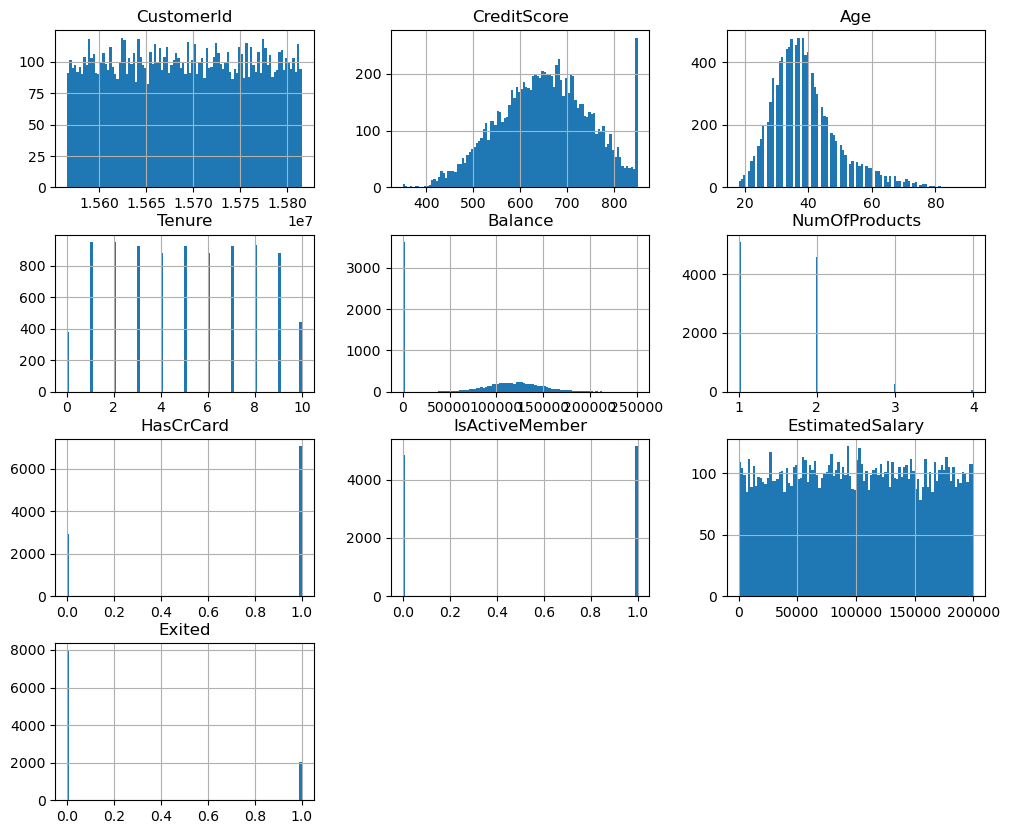

In [199]:
df = pd.read_csv('D:\Yandex.Practicum\projects\Churn.csv', sep=',', index_col='RowNumber')
df.info()
df.hist(bins=100, figsize=(12,10))
df.head()

Всего 10 000 клиентов.  
Из полученных данных видно, что параметр - кредитный рейтинг имеет нормальное распределение со смещением влево с резким выбросом в мааксимальном значении возможного рейтинга.  
Основная часть клиентов, больше 90%, пользуются 1-2 продуктами банка. При этом количество использующих 1 продукт приблизительно равно количеству испозьзующих 2 продукта. 3 и 4 продукта ипользует очень мало клиентов.  
70% клиентов пользуются кредитной картой.  
Немного больше половины клиентов неактивны.  
Около 20% клиентов прекратили пользоваться услугами. 

In [200]:
print(sum(df['Exited'] == 1))#кол-во ушедших
print(sum(df['Balance'] == 0))#кол-во клиентов с нулевым балансом
df[(df['Balance']==0) & (df['Exited']==1)]['Age'].count()#кол-во ушедших с нулевым балансом

2037
3617


500

Седьмая часть клиентов, которая не имела денег на балансе, отказалась от банковских услуг 

In [201]:
print(sum(df['CreditScore']>=600))
print(df[(df['Balance']==0) & (df['CreditScore']>=600)]['Age'].count())
df[(df['Exited']==1) & (df['CreditScore']>=600)]['Age'].count()

6966
2493


1377

Более половины (68%) ушедших клиентов имели хороший БКР (>600)

In [202]:
import plotly.express as px
fig = px.scatter(df, x='Balance', y='CreditScore', opacity=0.6)
fig.show()

БКР никак не связан с балансом

In [203]:
fig = px.scatter(df[df['Exited']==1], x='Balance', y='CreditScore', opacity=0.6)
fig.show()

In [204]:
df[['CreditScore', 'Balance']].corr()

,CreditScore,Balance
CreditScore,1.000000,0.006268
Balance,0.006268,1.000000


In [205]:
df[df['Exited']==0][['CreditScore', 'Balance']].corr()

,CreditScore,Balance
CreditScore,1.000000,0.007613
Balance,0.007613,1.000000


In [206]:
df[df['Exited']==1][['CreditScore', 'Balance']].corr()

,CreditScore,Balance
CreditScore,1.000000,0.017386
Balance,0.017386,1.000000


Наблюдается увеличениее корреляции между БКР и балансом ушедших клиентов, по сравнению со всеми клиентами, однако ее значение не столь велико, чтобы сделать из этого однозначные выводы.

In [207]:
columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
df[columns].groupby('Exited').agg('mean')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,
0,651.853196,37.408389,5.022247,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.901834,91108.539337,1.475209,0.699067,0.360825,101465.677531


Клиенты, отказавшиеся от банковских продуктов, в среднем на 7.4 года старше и имели на 20 000 больше на балансе. Так же они были в 1.5 раза менее активны. Остальные признаки не имеют ощутимых различий.

In [209]:
print(df['Tenure'].unique())
print(sum(df['Tenure'] == 0))
df['Tenure'].isna().sum()


[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan]
382


909

Пропущенные данные вероятно не являются случайным пропускам число 0, так как количество пропуков троекратно превышает кол-во новых клиентов банка.  
Количество пропущенных данных в столбце *'Tenure'* составляет около 10% от общего числа строк, поэтому лучше всего заменить пропуски медианным значением

In [210]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Поменяем тип данных в столбце *'Tenure'* на целочисленные

In [211]:
df['Tenure'] = df['Tenure'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [212]:
df.columns = df.columns.str.lower()
df = df.rename(columns={'rownumber': 'row_number', 'customerid': 'customer_id', 'creditscore': 'credit_score', 
                   'numofproducts': 'num_of_products', 'hascrcard': 'has_cr_card', 'isactivemember': 'is_active_member',
                    'estimatedsalary': 'estimated_salary'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   surname           10000 non-null  object 
 2   credit_score      10000 non-null  int64  
 3   geography         10000 non-null  object 
 4   gender            10000 non-null  object 
 5   age               10000 non-null  int64  
 6   tenure            10000 non-null  int64  
 7   balance           10000 non-null  float64
 8   num_of_products   10000 non-null  int64  
 9   has_cr_card       10000 non-null  int64  
 10  is_active_member  10000 non-null  int64  
 11  estimated_salary  10000 non-null  float64
 12  exited            10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


Проверим взаимосвязь данных, для этого выведем матрицу корреляций всех не количественных параметров

In [213]:
object_columns = ['row_number', 'customer_id', 'credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 
                  'is_active_member', 'estimated_salary', 'exited']

In [214]:
df.phik_matrix().round(2)

interval columns not set, guessing: ['customer_id', 'credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']


C:\Users\asus\AppData\Roaming\Python\Python39\site-packages\phik\data_quality.py:59: UserWarning:

The number of unique values of variable surname is large: 2932. Are you sure this is not an interval variable? Analysis for pairs of variables including surname can be slow.



,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,1.00,0.00,0.02,0.00,0.00,0.04,0.01,0.00,0.01,0.00,0.01,0.00,0.03
surname,0.00,1.00,0.24,0.00,0.04,0.33,0.04,0.48,0.20,0.00,0.00,0.08,0.00
credit_score,0.02,0.24,1.00,0.04,0.00,0.00,0.00,0.00,0.03,0.00,0.04,0.03,0.10
geography,0.00,0.00,0.04,1.00,0.01,0.09,0.00,0.46,0.05,0.00,0.01,0.03,0.10
gender,0.00,0.04,0.00,0.01,1.00,0.03,0.03,0.00,0.06,0.00,0.03,0.03,0.17
age,0.04,0.33,0.00,0.09,0.03,1.00,0.04,0.04,0.15,0.02,0.19,0.05,0.49
tenure,0.01,0.04,0.00,0.00,0.03,0.04,1.00,0.06,0.06,0.03,0.03,0.00,0.02
balance,0.00,0.48,0.00,0.46,0.00,0.04,0.06,1.00,0.37,0.05,0.02,0.00,0.18
num_of_products,0.01,0.20,0.03,0.05,0.06,0.15,0.06,0.37,1.00,0.00,0.06,0.03,0.57
has_cr_card,0.00,0.00,0.00,0.00,0.00,0.02,0.03,0.05,0.00,1.00,0.01,0.00,0.00


Между признаком столбца exited и возрастом клиента, а также количеством продуктов банка присутствует средняя корреляция

Выделим признаки для обучения модели и целевой признак.  
Столбец exited - целевой признак.  
Все остальные солбцы принимаем в качестве признаков, кроме row_number, customer_id и surname, так как они используются для идентификации клиента

In [216]:
features = df.drop(['customer_id', 'surname', 'exited'], axis=1)
target = df['exited']

Преобразуем категориальные признаки в численные с помощью OHE, избегаем дамми-ловушку

In [217]:
features = pd.get_dummies(data=features, columns=['geography', 'gender'], drop_first=True)

Теперь разделим весь датасет на выборки - обучающую валидационную и тестовую в соотношении 3:1:1

In [218]:
features_train, features_other, target_train, target_other = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)

In [220]:
features_valid, features_test, target_valid, target_test = train_test_split(features_other, target_other, test_size=0.5, 
                                                                            random_state=12345, stratify=target_other)

In [221]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
features_test.shape, target_test.shape

(6000, 11) (6000,)
(2000, 11) (2000,)


((2000, 11), (2000,))

Масштабируем количественные признаки, чтобы их сбалансировать

In [222]:
scaler = StandardScaler()
columns_to_scale = ['credit_score','age','tenure', 'balance', 'estimated_salary', 'num_of_products']
features_train[columns_to_scale] = scaler.fit_transform(features_train[columns_to_scale])
features_valid[columns_to_scale] = scaler.fit_transform(features_valid[columns_to_scale])
features_test[columns_to_scale] = scaler.fit_transform(features_test[columns_to_scale])

## Шаг 2.	Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.

Обучим три вида модели: решающее дерево, случайный лес и логистическая регрессия. В каждой модели возьмем лучший набор гиперпараметров и проверим на валидационной выборке.

### Решающее дерево

In [223]:
%%time
best_model_tree = None
best_tree_accuracy = 0
best_tree_f1 = 0
best_tree_f1_train = 0
best_depth = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 300):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    predictions_train = model.predict(features_train)
    f1_valid = f1_score(target_valid, predictions_valid)
    f1_train = f1_score(target_train, predictions_train)
    f1_change_train.append(f1_train)
    f1_change_valid.append(f1_valid)
    if best_tree_f1 < f1_valid:
        best_model_tree = model
        best_tree_f1 = f1_valid
        best_tree_f1_train = f1_train
        best_depth = depth
        best_tree_accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{best_tree_f1},\n'
f'F1 на обучающей выборке:{best_tree_f1_train},\n'
f'accurasy:{best_tree_accuracy},\n'
f'глубина дерева:{best_depth}')

F1 найлучшей модели на валидационной выборке:0.5950653120464441,
F1 на обучающей выборке:0.6115288220551378,
accurasy:0.8605,
глубина дерева:7
CPU times: total: 9.89 s
Wall time: 9.92 s


In [224]:
import plotly
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(x = np.arange(1, 50), y=f1_change_train, name='F1 train'))
fig.add_trace(go.Scatter(x = np.arange(1, 50), y=f1_change_valid, name='F1 valid'))
fig.show()

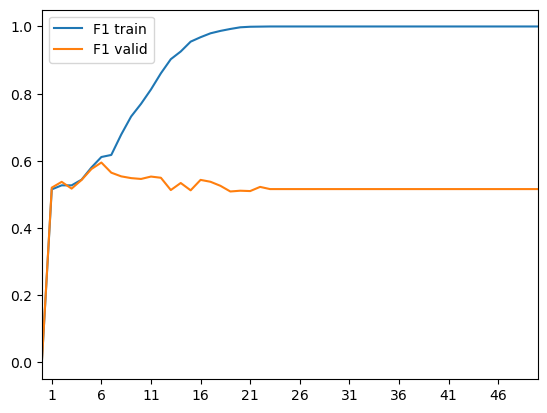

In [225]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,5))
plt.xlim([0, 50])
plt.legend()
plt.show()

После лучшего знчения F1 на валидационной выборке F1 на тренировочной выборке стремится к 1, что говорит о заучивании моделью ответов

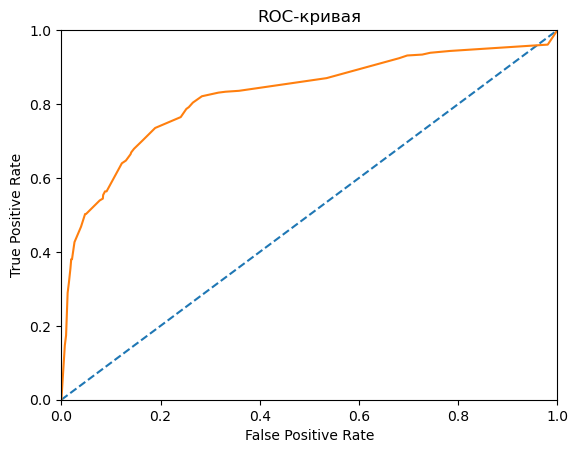

0.8235694403389496

In [226]:
probabilities_valid = best_model_tree.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Модель с высоким качеством получается при  tpr равном 0.8 и fpr около 0.2  
Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

### Случайный лес

In [227]:
%%time
best_model_forest = None
best_forest_accuracy = 0
best_forest_f1 = 0
best_forest_f1_train = 0
best_depth = 0
best_est = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 120):
    for est in range(1, 20):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        predictions_train = model.predict(features_train)
        f1_valid = f1_score(target_valid, predictions_valid)
        f1_train = f1_score(target_train, predictions_train)
        f1_change_train.append(f1_train)
        f1_change_valid.append(f1_valid)
        if best_forest_f1 < f1_valid:
            best_model_forest = model
            best_forest_f1 = f1_valid
            best_forest_f1_train = f1_train
            best_depth = depth
            best_est = est
            best_forest_accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{best_forest_f1},\n'
f'F1 на обучающей выборке:{best_forest_f1_train},\n'
f'accurasy:{best_forest_accuracy},\n'
f'количество деревьев:{best_est},\n'
f'глубина дерева:{best_depth}')

F1 найлучшей модели на валидационной выборке:0.6251808972503619,
F1 на обучающей выборке:0.9689075630252102,
accurasy:0.8705,
количество деревьев:19,
глубина дерева:17
CPU times: total: 3min 11s
Wall time: 3min 11s


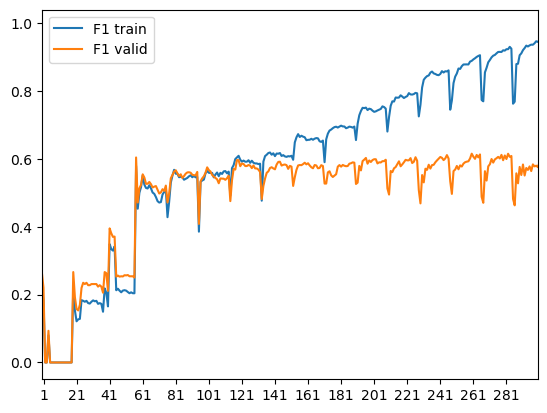

In [228]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,20))
plt.xlim([0, 300])
plt.legend()
plt.show()

Случайный лес показывает почти 100% заучивание на тренировочной выбоке при наивысшем показателе F1 на валидационной

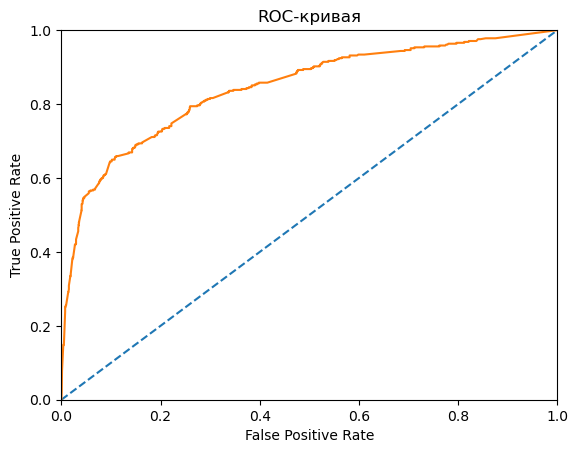

0.8429617449995073

In [229]:
probabilities_valid = best_model_forest.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Модель с высоким качеством получается при  tpr равном 0.8 и fpr около 0.2  
Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

### Логистическая регрессия

In [230]:
model_regression = LogisticRegression(random_state=12345)
model_regression.fit(features_train, target_train)
predictions_train = model_regression.predict(features_train)
predictions_valid = model_regression.predict(features_valid)
f1_train = f1_score(target_train, predictions_train)
f1_valid = f1_score(target_valid, predictions_valid)
accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{f1_valid},\n'
f'F1 на обучающей выборке:{f1_train},\n'
f'accurasy:{accuracy},\n')

F1 найлучшей модели на валидационной выборке:0.3107861060329068,
F1 на обучающей выборке:0.3190332326283987,
accurasy:0.8115,



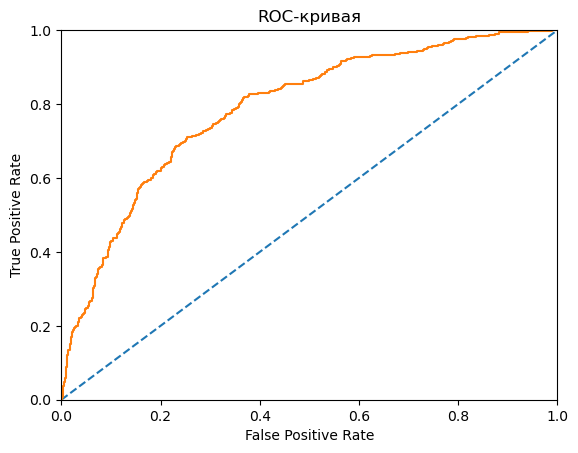

0.7876653488028377

In [231]:
probabilities_valid = model_regression.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

Итог: 
решающее дерево: F1 = 0.60, случайный лес: F1 = 0.63, логистическая регрессия: F1 = 0.32  
Найлучший результат без учета дисбаланса показывает модель - случайный лес, она же имеет самую высокую метрику AUC-ROC = 0.84


## Шаг 3. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.

### Вес классов сбалансируем с помощью аргумента class_weight='balanced'

### Решающеее дерево

In [232]:
%%time
best_model_tree_balanced = None
best_tree_accuracy = 0
best_tree_f1 = 0
best_tree_f1_train = 0
best_depth = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 300):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    predictions_train = model.predict(features_train)
    f1_valid = f1_score(target_valid, predictions_valid)
    f1_train = f1_score(target_train, predictions_train)
    f1_change_train.append(f1_train)
    f1_change_valid.append(f1_valid)
    if best_tree_f1 < f1_valid:
        best_model_tree_balanced = model
        best_tree_f1 = f1_valid
        best_tree_f1_train = f1_train
        best_depth = depth
        best_tree_accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{best_tree_f1},\n'
f'F1 на обучающей выборке:{best_tree_f1_train},\n'
f'accurasy:{best_tree_accuracy},\n'
f'глубина дерева:{best_depth}')

F1 найлучшей модели на валидационной выборке:0.5764596848934197,
F1 на обучающей выборке:0.6022623051054724,
accurasy:0.7715,
глубина дерева:6
CPU times: total: 9.56 s
Wall time: 9.57 s


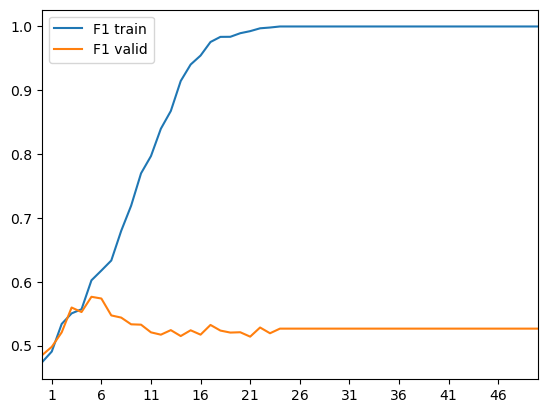

In [233]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,5))
plt.xlim([0, 50])
plt.legend()
plt.show()

После лучшего знчения F1 на валидационной выборке F1 на тренировочной выборке стремится к 1, что говорит о заучивании моделью ответов

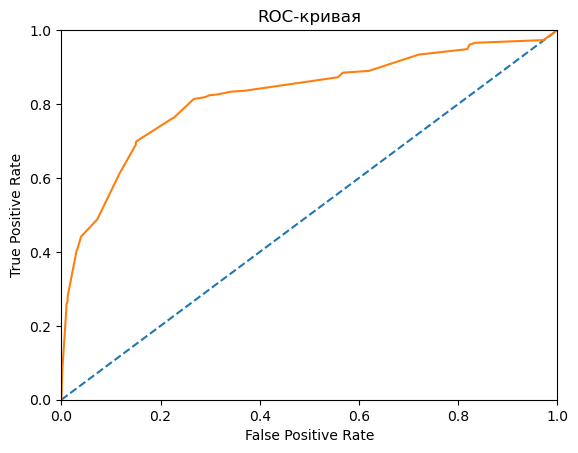

0.8219359665976944

In [234]:
probabilities_valid = best_model_tree_balanced.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Модель с высоким качеством получается при  tpr равном 0.8 и fpr около 0.2  
Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

Наблюдается небольшое ухудшение показателей модели после взвешивания классов

### Случайный лес

In [235]:
%%time
best_model_forest_balanced = None
best_forest_accuracy = 0
best_forest_f1 = 0
best_forest_f1_train = 0
best_depth = 0
best_est = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 120):
    for est in range(1, 20):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        predictions_train = model.predict(features_train)
        f1_valid = f1_score(target_valid, predictions_valid)
        f1_train = f1_score(target_train, predictions_train)
        f1_change_train.append(f1_train)
        f1_change_valid.append(f1_valid)
        if best_forest_f1 < f1_valid:
            best_model_forest_balanced = model
            best_forest_f1 = f1_valid
            best_forest_f1_train = f1_train
            best_depth = depth
            best_est = est
            best_forest_accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{best_forest_f1},\n'
f'F1 на обучающей выборке:{best_forest_f1_train},\n'
f'accurasy:{best_forest_accuracy},\n'
f'количество деревьев:{best_est},\n'
f'глубина дерева:{best_depth}')

F1 найлучшей модели на валидационной выборке:0.6469893742621016,
F1 на обучающей выборке:0.7982799061767005,
accurasy:0.8505,
количество деревьев:19,
глубина дерева:10
CPU times: total: 3min 10s
Wall time: 3min 10s


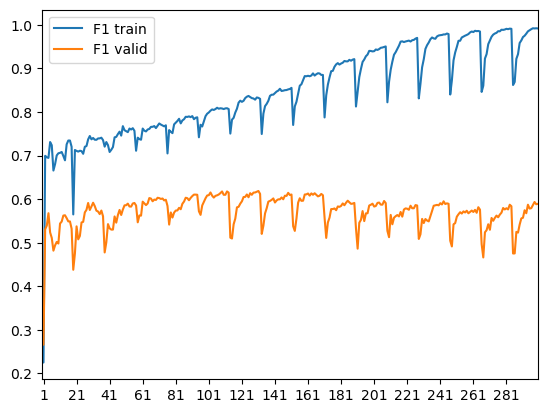

In [263]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,20))
plt.xlim([0, 300])
plt.legend()
plt.show()

После взвешивания классов модель больше не показывает зайчивание на тренировочной выборке, при этом метрика F1 на валидоционной выборке выросла с 0.63 до 0.65, что говорит об улучшении качества модели

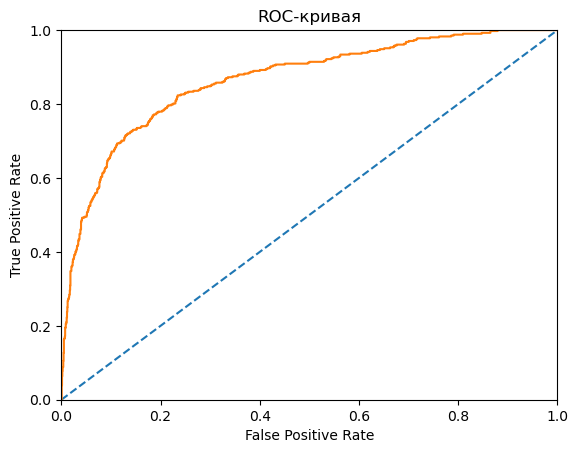

0.8639105453739284

In [237]:
probabilities_valid = best_model_forest_balanced.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Метрика AUC-ROC выросла после взвешивания классов  
Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

### Логистическая регрессия

In [238]:
model_regression_balanced = LogisticRegression(random_state=12345, class_weight='balanced')
model_regression_balanced.fit(features_train, target_train)
predictions_train = model_regression_balanced.predict(features_train)
predictions_valid = model_regression_balanced.predict(features_valid)
f1_train = f1_score(target_train, predictions_train)
f1_valid = f1_score(target_valid, predictions_valid)
accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{f1_valid},\n'
f'F1 на обучающей выборке:{f1_train},\n'
f'accurasy:{accuracy},\n')

F1 найлучшей модели на валидационной выборке:0.525764192139738,
F1 на обучающей выборке:0.4879765395894428,
accurasy:0.7285,



Значительно увеличилась метрика F1 после взвешивания классов. Теперь модель правильно классифицирует 53%, вместо 32%, всех положительных и отрицательных данных 

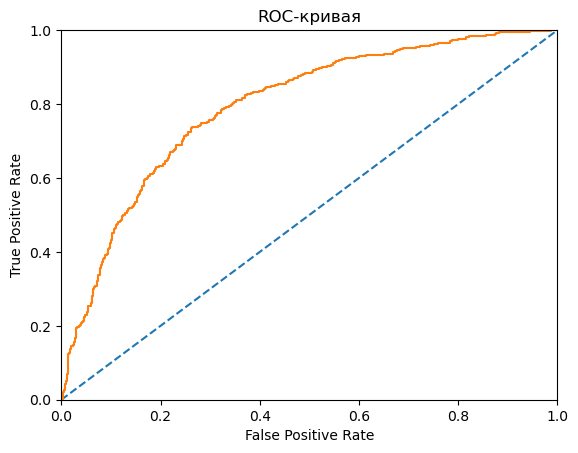

0.7937327569218643

In [239]:
probabilities_valid = model_regression_balanced.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

Итог: 
решающее дерево: F1 = 0.58, случайный лес: F1 = 0.65, логистическая регрессия: F1 = 0.53  
Найлучший результат без учета дисбаланса показывает модель - случайный лес, она же имеет самую высокую метрику AUC-ROC = 0.86  
В общем взвешивание класса не дало ощутимого результата, поэтому применим методы уменьшения или увеличения выборки для сбалансирования числа классов

### Сбалансируем вес классов путем уменьшения выборки методом downsampling

Проверим разницу количества примеров между классами

In [240]:
target.value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [241]:
2037/7963

0.25580811252040686

Разница составляет 3.91

In [242]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, 0.256)

In [243]:
print(features_downsampled_train.value_counts())
target_downsampled_train.value_counts()

credit_score  age        tenure     balance    num_of_products  has_cr_card  is_active_member  estimated_salary  geography_Germany  geography_Spain  gender_Male
-3.091423      1.143958   1.814142  -1.219673  -0.914708        1            1                  0.441837         0                  0                1              1
 0.423086     -0.190567   0.723985   0.746514  -0.914708        1            1                 -0.038962         1                  0                0              1
 0.412780      0.762665  -1.092943  -1.219673   0.820981        1            0                  0.885971         0                  0                1              1
               1.429928  -1.456328   1.081383  -0.914708        1            1                  0.144737         1                  0                0              1
 0.423086     -1.429769   0.360600  -1.219673   0.820981        1            1                 -0.131975         0                  0                1              1
         

0    1223
1    1222
Name: exited, dtype: int64

In [244]:
features_downsampled_train['num_of_products'].value_counts()

-0.914708    1405
 0.820981     877
 2.556669     131
 4.292357      32
Name: num_of_products, dtype: int64

### Решающеее дерево

In [245]:
%%time
best_model_tree_downscaled = None
best_tree_accuracy = 0
best_tree_f1 = 0
best_tree_f1_train = 0
best_depth = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 300):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_downsampled_train, target_downsampled_train)
    predictions_valid = model.predict(features_valid)
    predictions_train = model.predict(features_downsampled_train)
    f1_valid = f1_score(target_valid, predictions_valid)
    f1_train = f1_score(target_downsampled_train, predictions_train)
    f1_change_train.append(f1_train)
    f1_change_valid.append(f1_valid)
    if best_tree_f1 < f1_valid:
        best_model_tree_downscaled = model
        best_tree_f1 = f1_valid
        best_tree_f1_train = f1_train
        best_depth = depth
        best_tree_accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{best_tree_f1},\n'
f'F1 на обучающей выборке:{best_tree_f1_train},\n'
f'accurasy:{best_tree_accuracy},\n'
f'глубина дерева:{best_depth}')

F1 найлучшей модели на валидационной выборке:0.594900849858357,
F1 на обучающей выборке:0.802021903959562,
accurasy:0.7855,
глубина дерева:6
CPU times: total: 4.75 s
Wall time: 4.75 s


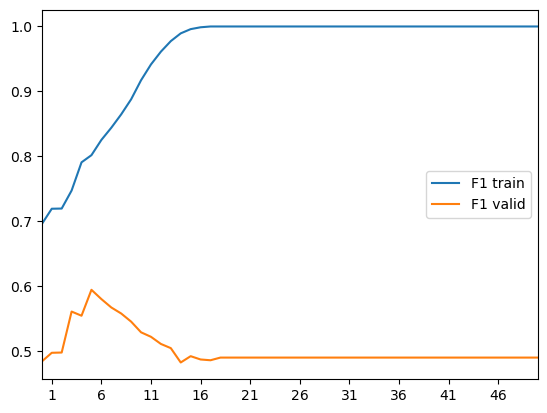

In [246]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,5))
plt.xlim([0, 50])
plt.legend()
plt.show()

После лучшего знчения F1 на валидационной выборке F1 на тренировочной выборке стремится к 1, что говорит о заучивании моделью ответов

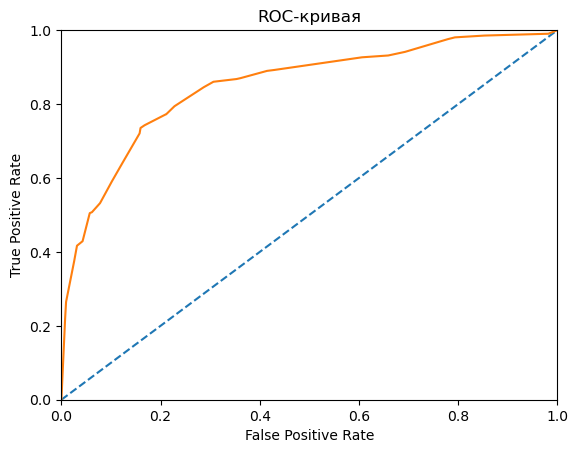

0.8491015124642821

In [247]:
probabilities_valid = best_model_tree_downscaled.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Модель с высоким качеством получается при  tpr равном 0.8 и fpr около 0.2  
Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

### Случайный лес

In [248]:
%%time
best_model_forest_downscaled = None
best_forest_accuracy = 0
best_forest_f1 = 0
best_forest_f1_train = 0
best_depth = 0
best_est = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 120):
    for est in range(1, 20):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        model.fit(features_downsampled_train, target_downsampled_train)
        predictions_valid = model.predict(features_valid)
        predictions_train = model.predict(features_downsampled_train)
        f1_valid = f1_score(target_valid, predictions_valid)
        f1_train = f1_score(target_downsampled_train, predictions_train)
        f1_change_train.append(f1_train)
        f1_change_valid.append(f1_valid)
        if best_forest_f1 < f1_valid:
            best_model_forest_downscaled = model
            best_forest_f1 = f1_valid
            best_forest_f1_train = f1_train
            best_depth = depth
            best_est = est
            best_forest_accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{best_forest_f1},\n'
f'F1 на обучающей выборке:{best_forest_f1_train},\n'
f'accurasy:{best_forest_accuracy},\n'
f'количество деревьев:{best_est},\n'
f'глубина дерева:{best_depth}')

F1 найлучшей модели на валидационной выборке:0.6188166828322017,
F1 на обучающей выборке:0.8324786324786324,
accurasy:0.8035,
количество деревьев:18,
глубина дерева:7
CPU times: total: 1min 42s
Wall time: 1min 42s


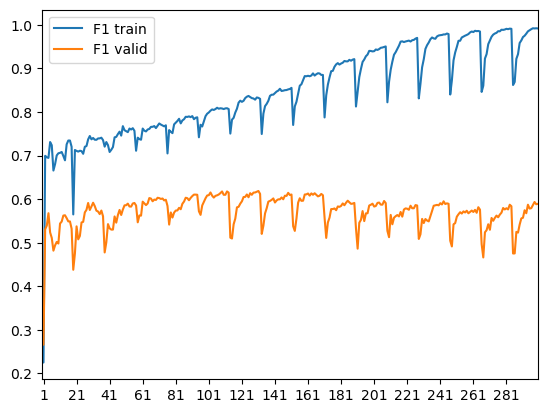

In [249]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,20))
plt.xlim([0, 300])
plt.legend()
plt.show()

Случайный лес показывает почти 100% заучивание на тренировочной выбоке при наивысшем показателе F1 на валидационной

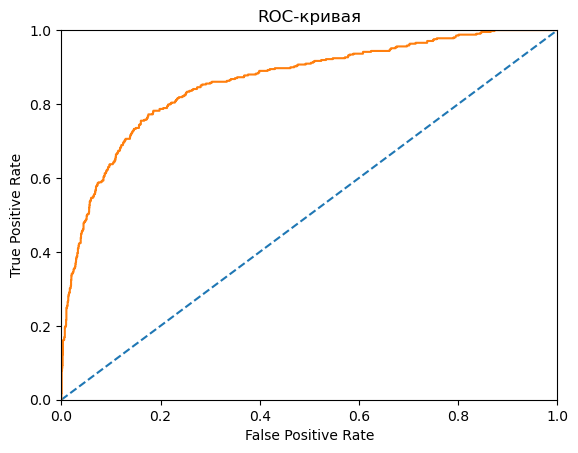

0.8609391935166025

In [250]:
probabilities_valid = best_model_forest_downscaled.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Модель с высоким качеством получается при  tpr равном 0.8 и fpr около 0.2  
Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

### Логистическая регрессия

In [251]:
model_regression_downscaled = LogisticRegression(random_state=12345)
model_regression_downscaled.fit(features_downsampled_train, target_downsampled_train)
predictions_train = model_regression_downscaled.predict(features_downsampled_train)
predictions_valid = model_regression_downscaled.predict(features_valid)
f1_train = f1_score(target_downsampled_train, predictions_train)
f1_valid = f1_score(target_valid, predictions_valid)
accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{f1_valid},\n'
f'F1 на обучающей выборке:{f1_train},\n'
f'accurasy:{accuracy},\n')

F1 найлучшей модели на валидационной выборке:0.5251299826689775,
F1 на обучающей выборке:0.6941323345817727,
accurasy:0.726,



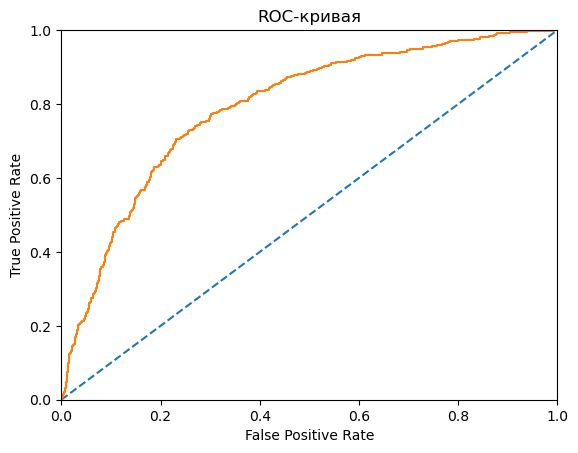

0.7925965612375603

In [252]:
probabilities_valid = model_regression_downscaled.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

Итог: 
решающее дерево: F1 = 0.60, случайный лес: F1 = 0.63, логистическая регрессия: F1 = 0.32  
Найлучший результат без учета дисбаланса показывает модель - случайный лес, она же имеет самую высокую метрику AUC-ROC = 0.84


### Сбалансируем вес классов путем увеличения выборки методом upsampling

In [265]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, 4)

In [266]:
target_upsampled_train.value_counts()

1    4888
0    4778
Name: exited, dtype: int64

### Решающеее дерево

In [267]:
%%time
best_model_tree_upscaled = None
best_tree_accuracy = 0
best_tree_f1 = 0
best_tree_f1_train = 0
best_depth = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 300):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_upsampled_train, target_upsampled_train)
    predictions_valid = model.predict(features_valid)
    predictions_train = model.predict(features_upsampled_train)
    f1_valid = f1_score(target_valid, predictions_valid)
    f1_train = f1_score(target_upsampled_train, predictions_train)
    f1_change_train.append(f1_train)
    f1_change_valid.append(f1_valid)
    if best_tree_f1 < f1_valid:
        best_model_tree_upscaled = model
        best_tree_f1 = f1_valid
        best_tree_f1_train = f1_train
        best_depth = depth
        best_tree_accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{best_tree_f1},\n'
f'F1 на обучающей выборке:{best_tree_f1_train},\n'
f'accurasy:{best_tree_accuracy},\n'
f'глубина дерева:{best_depth}')

F1 найлучшей модели на валидационной выборке:0.5764596848934197,
F1 на обучающей выборке:0.7966033158107562,
accurasy:0.7715,
глубина дерева:6
CPU times: total: 13.4 s
Wall time: 13.4 s


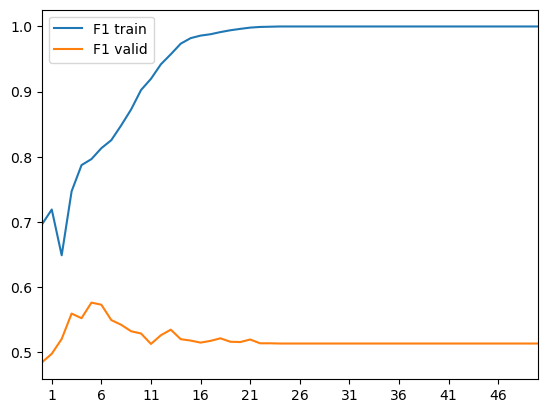

In [268]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,5))
plt.xlim([0, 50])
plt.legend()
plt.show()

После лучшего знчения F1 на валидационной выборке F1 на тренировочной выборке стремится к 1, что говорит о заучивании моделью ответов

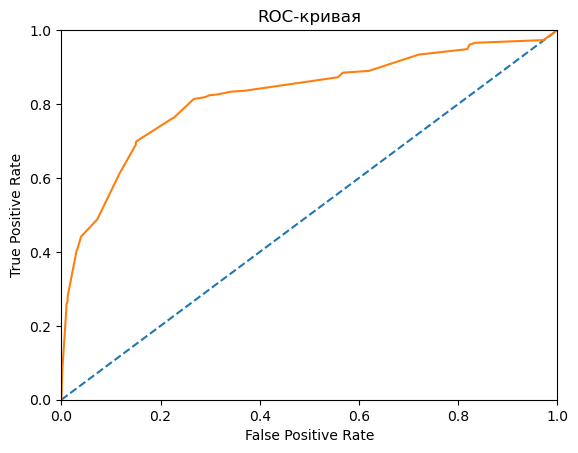

0.8219359665976944

In [269]:
probabilities_valid = best_model_tree_upscaled.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Модель с высоким качеством получается при  tpr равном 0.8 и fpr около 0.2  
Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

### Случайный лес

In [270]:
%%time
best_model_forest_upscaled = None
best_forest_accuracy = 0
best_forest_f1 = 0
best_forest_f1_train = 0
best_depth = 0
best_est = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 120):
    for est in range(1, 20):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        model.fit(features_upsampled_train, target_upsampled_train)
        predictions_valid = model.predict(features_valid)
        predictions_train = model.predict(features_upsampled_train)
        f1_valid = f1_score(target_valid, predictions_valid)
        f1_train = f1_score(target_upsampled_train, predictions_train)
        f1_change_train.append(f1_train)
        f1_change_valid.append(f1_valid)
        if best_forest_f1 < f1_valid:
            best_model_forest_upscaled = model
            best_forest_f1 = f1_valid
            best_forest_f1_train = f1_train
            best_depth = depth
            best_est = est
            best_forest_accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{best_forest_f1},\n'
f'F1 на обучающей выборке:{best_forest_f1_train},\n'
f'accurasy:{best_forest_accuracy},\n'
f'количество деревьев:{best_est},\n'
f'глубина дерева:{best_depth}')

F1 найлучшей модели на валидационной выборке:0.6443701226309921,
F1 на обучающей выборке:0.9412722646310433,
accurasy:0.8405,
количество деревьев:14,
глубина дерева:11
CPU times: total: 4min 22s
Wall time: 4min 23s


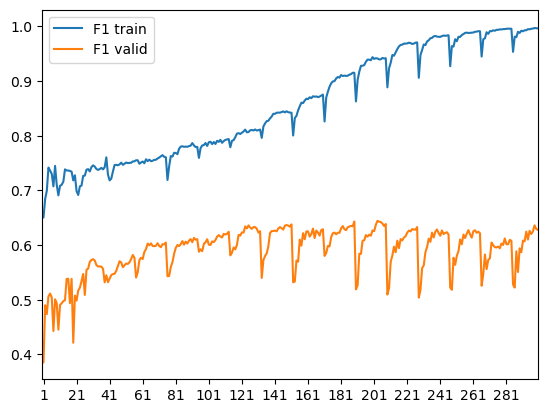

In [276]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,20))
plt.xlim([0, 300])
plt.legend()
plt.show()

Случайный лес показывает почти 100% заучивание на тренировочной выбоке при наивысшем показателе F1 на валидационной

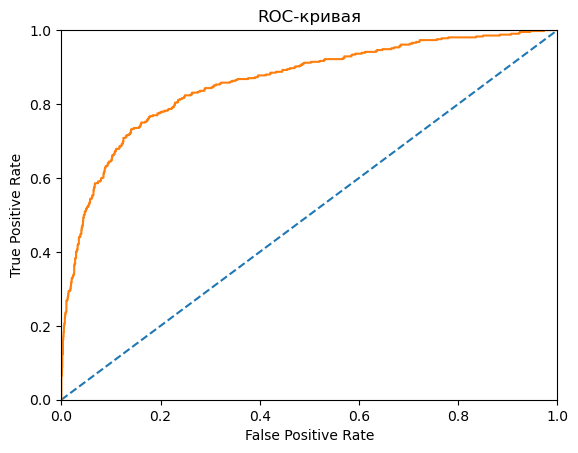

0.8587614851216868

In [272]:
probabilities_valid = best_model_forest_upscaled.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Модель с высоким качеством получается при  tpr равном 0.8 и fpr около 0.2  
Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

### Логистическая регрессия

In [273]:
model_regression_upscaled = LogisticRegression(random_state=12345)
model_regression_upscaled.fit(features_upsampled_train, target_upsampled_train)
predictions_train = model_regression_upscaled.predict(features_upsampled_train)
predictions_valid = model_regression_upscaled.predict(features_valid)
f1_train = f1_score(target_upsampled_train, predictions_train)
f1_valid = f1_score(target_valid, predictions_valid)
accuracy = accuracy_score(target_valid, predictions_valid)
print(f'F1 найлучшей модели на валидационной выборке:{f1_valid},\n'
f'F1 на обучающей выборке:{f1_train},\n'
f'accurasy:{accuracy},\n')

F1 найлучшей модели на валидационной выборке:0.5254091300602928,
F1 на обучающей выборке:0.6993992127615496,
accurasy:0.7245,



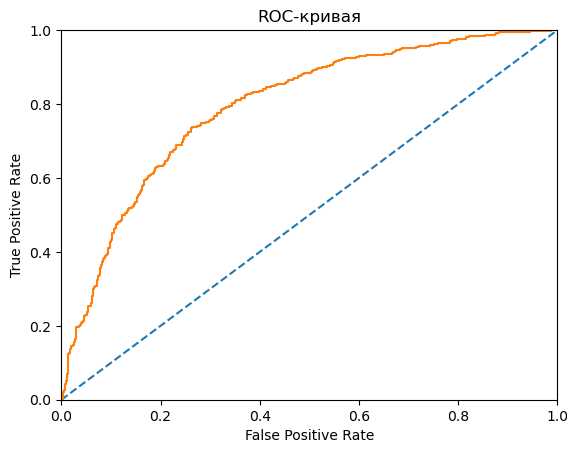

0.793791260222682

In [274]:
probabilities_valid = model_regression_upscaled.predict_proba(features_valid)#
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, tresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')# ROC кривая случайной модели
plt.plot(fpr, tpr)# ROC кривая модели решающего дерева
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_valid, probabilities_one_valid)

Значение метрики ROC-AUC показывает, что наша модель лучше предсказывает целевой признак, чем случайный классификатор

Итог: 
решающее дерево: F1 = 0.60, случайный лес: F1 = 0.63, логистическая регрессия: F1 = 0.32  
Найлучший результат без учета дисбаланса показывает модель - случайный лес, она же имеет самую высокую метрику AUC-ROC = 0.84


## Шаг 4. Финальное тестирование лучшей модели

In [281]:
predictions_test = best_model_forest_balanced.predict(features_test)
f1_test = f1_score(target_test, predictions_test)
print(f'F1 наилучшей модели на тестовой выборке: {f1_test}')

F1 наилучшей модели на тестовой выборке: 0.5755053507728894


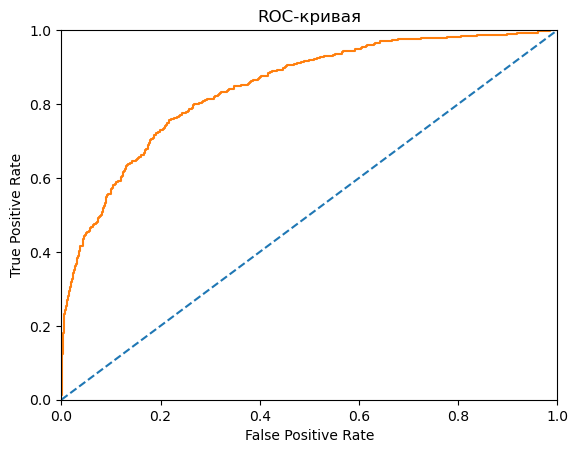

0.8439117083184879

In [282]:
probabilities_test = best_model_forest_balanced.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, tresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_test, probabilities_one_test)

In [283]:
predictions_test = best_model_forest_upscaled.predict(features_test)
f1_test = f1_score(target_test, predictions_test)
print(f'F1 наилучшей модели на тестовой выборке: {f1_test}')

F1 наилучшей модели на тестовой выборке: 0.5910652920962199


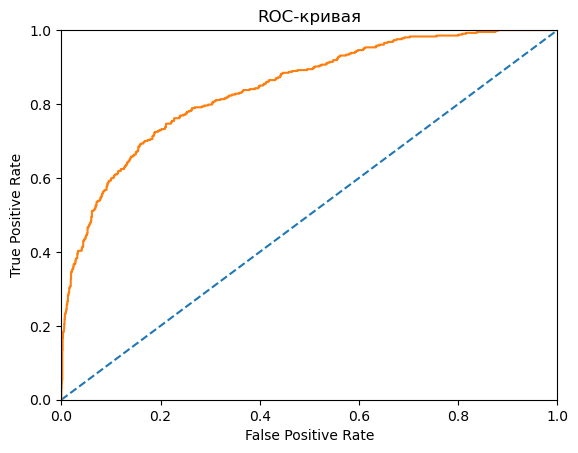

0.8433024704211145

In [284]:
probabilities_test = best_model_forest_upscaled.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, tresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
roc_auc_score(target_test, probabilities_one_test)

У модели случайного леса, обученной на тренировочной выборке сбалансированной гиперпараметром class_weight, метрика F1 немного выше, выбираем ее.

## Шаг 5. Вывод
Для того чтобы обучить наилучшую модель с показателем F1 не менее 0.59 мной была проделана следующая работа:

1. Общий обзор данных, собрал информацию о признаках для выборок
2. Подготовил данные к обучению модели, разделил на тренировочную, валидационную и тренировочную выборки(без учета баланса классов)
3. Подобрал параметры и обучил 3 различные модели - логистисческая регрессия, случайный лес и дерево решений, сравнил метрики качества предсказаний
4. Провел повторное обучение моделей, но уже с учетом баланса классов - получилось улучшить качество предсказаний всех моделей и выбрать лучшую
5. Провел финальный тест выбранной модели

*Для предсказаний целевого признака выберем модель с наилучшим результатом - случайный лес*
Модель поможет банку предсказать, что клиент с высокой вероятностью перестанет пользоваться его услугами, этому клиенту можно будет предложить лучший тариф/скидку/другие условия по банковским продуктам, что будет более выгодным для банка, чем привлекать нового клиента.